<a href="https://colab.research.google.com/github/Trickshotblaster/nn-practices/blob/main/actual_words.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch

In [2]:
!pip install transformers
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 30.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 41.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 16.2 MB/s eta 0:00:00


In [3]:
tokenizer.vocab_size

30522

In [4]:
output = tokenizer.encode("Hello, y'all! How are you 😁 ?")
out_tensor = torch.tensor(output)

In [5]:
out_tensor

tensor([ 101, 7592, 1010, 1061, 1005, 2035,  999, 2129, 2024, 2017,  100, 1029,
         102])

In [6]:
tokenizer.decode(out_tensor)

"[CLS] hello, y'all! how are you [UNK]? [SEP]"

In [7]:
import requests
import io

# Get the content of the page
response = requests.get("https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt")

# Write the content to a file
with io.open('traintext.txt', 'w', encoding='utf-8') as f:
    f.write(response.text)

In [8]:
with open("traintext.txt", 'r') as f:
  text = f.readlines()

In [9]:
text[:10]

['First Citizen:\n',
 'Before we proceed any further, hear me speak.\n',
 '\n',
 'All:\n',
 'Speak, speak.\n',
 '\n',
 'First Citizen:\n',
 'You are all resolved rather to die than to famish?\n',
 '\n',
 'All:\n']

In [10]:
import random

In [11]:
text_len = len(text) - 1

In [12]:
context_len = 10
emb_dim = 20
#tokenizer.enable_truncation(context_len)
#tokenizer.enable_padding(direction='left', length=context_len)

pretokenize? aaaa but it takes so long

In [13]:
pretokenized_text = [tokenizer.encode(t) for t in text]

In [14]:
vocab_size = tokenizer.vocab_size

In [15]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [16]:
tokenizer.pad_token_id

0

In [17]:
def make_batch(batch):
  xs = []
  ys = []
  for sentence in batch:
    context = [0] * context_len
    for word, next in zip(sentence, sentence[1:]):
      context = context[1:] + [word]
      xs.append(context)
      ys.append(next)
  xs = torch.tensor(xs).to(device)
  ys = torch.tensor(ys).to(device)
  return xs, ys

In [86]:
n_hidden = 100

In [99]:
C = torch.randn((vocab_size, emb_dim)).to(device)
w1 = torch.randn((emb_dim * context_len, n_hidden)).to(device) * 0.01
b1 = torch.randn(n_hidden).to(device) * 0.01
w2 = torch.randn((n_hidden, vocab_size)).to(device) * 0.01
b2 = torch.randn(vocab_size).to(device) * 0.01

bngain = torch.ones((1, n_hidden)).to(device)
bnbias = torch.zeros((1, n_hidden)).to(device)

params = [C, w1, b1, w2, b2, bngain, bnbias]
weights = [w1, w2]
for p in params:
  p.requires_grad = True

In [23]:
import torch.nn.functional as F

In [100]:
num_epochs = 20000
batch_size = 32
lr = 0.1

In [101]:
for epoch in range(num_epochs):
  batch = [pretokenized_text[random.randint(0, text_len)] for i in range(batch_size)]
  #words = torch.tensor([tokenizer.encode_batch(batch)[i].ids for i in range(batch_size)])
  x, y = make_batch(batch)

  emb = C[x].view(-1, emb_dim * context_len)
  l1preact = emb @ w1 + b1

  l1preact = bngain * (l1preact - l1preact.mean(0, keepdim=True)) / l1preact.std(0, keepdim=True) + bnbias
  l1 = l1preact.tanh()

  logits = l1 @ w2 + b2

  loss = F.cross_entropy(logits, y) + (torch.tensor([w.mean() for w in weights]).mean()) * 0.1

  for p in params:
    p.grad = None

  loss.backward()
  for p in params:
    p.data -= p.grad * (lr / min(1, (1000/(epoch+1))))
  if epoch % 1000 == 0:
    print(loss.item())

10.331833839416504
6.779977321624756
5.7544097900390625
5.332901954650879
5.056870460510254
5.1439290046691895
4.9821648597717285
5.005387306213379
5.110998630523682
4.458866119384766
4.899320125579834
4.4922027587890625
4.536121845245361
4.282560348510742
4.350934028625488
4.563571929931641
4.215357780456543
4.122247219085693
4.881522178649902
4.421703815460205


In [102]:
loss.log10().item()

0.6631532907485962

In [103]:
import matplotlib.pyplot as plt

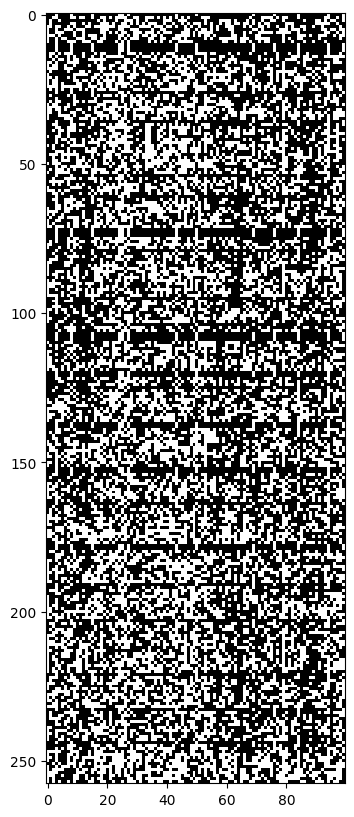

In [104]:
plt.figure(figsize=(20,10))
plt.imshow(l1.cpu().abs() > 0.99, cmap='gray', interpolation='nearest')

(array([9545., 1240.,  684.,  600.,  710.,  751.,  779., 1010., 1276.,
        9205.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <BarContainer object of 10 artists>)

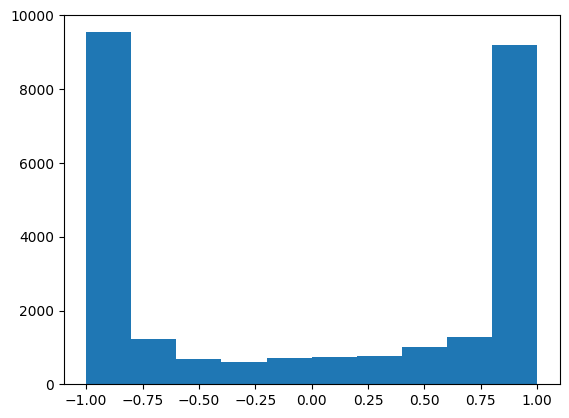

In [105]:
plt.hist(l1.view(-1).tolist())

In [106]:
@torch.no_grad()
def forward(text):
  ins = text
  x = tokenizer.encode(text)
  context = [0] * (context_len - len(x)) + x if (context_len - len(x)) > 0 else x[:-context_len]
  context = torch.tensor(context)
  emb = C[context].view(-1, emb_dim * context_len)
  l1 = (emb @ w1 + b1).tanh()
  out = (l1 @ w2 + b2).tanh()
  out = out.exp()
  out /= out.sum(1, keepdim=True)
  sampled = torch.multinomial(out, num_samples=1)
  return sampled

In [107]:
def numerical_forward(cont):
  cont = torch.tensor(cont).to(device)
  emb = C[cont].view(-1, emb_dim * context_len)
  l1 = (emb @ w1 + b1).tanh()
  out = (l1 @ w2 + b2).tanh()
  out = out.exp()
  out /= out.sum(1, keepdim=True)
  sampled = torch.multinomial(out, num_samples=1)
  return sampled

In [108]:
lol = forward('Romeo')
print(lol)
tokenizer.decode(lol[0][0])

tensor([[11250]], device='cuda:0')


'bothered'

ok this is actually crazy it said thou

In [109]:
tokenizer.vocab_size

30522

In [110]:
def cont(text, max_len=20):
  x = tokenizer.encode(text)
  context = [0] * (context_len - len(x)) + x if (context_len - len(x)) > 0 else x[:-context_len]

  for x in range(max_len):

    context.append(numerical_forward(context).cpu().numpy()[0][0])
    context = context[1:]

  return tokenizer.decode(context)

cont("Romeo")

'##urst cuckoo reel member triangles northwesternlov buddha reputation piccolo'

In [ ]:
tokenizer.encode("[UNK]")

[101, 100, 102]

In [ ]:
tokenizer.vocab_size

30522